# NAPS graphics for the manuscript

## After NAPS

In [4]:
import os

# Set the working directory
os.chdir('../../')

# Verify the current working directory
print("Current working directory:", os.getcwd())

Current working directory: /scratch/gpfs/swwolf/git/snakemake-sleap-naps


In [4]:
# sleap-convert --format analysis example-output/project_1/output/example_video_1.mp4_naps_results.slp -o example-output/project_1/output/example_video_1.mp4_naps_results.analysis.h5
# sleap-convert --format analysis example-output/project_1/output/example_video_1.mp4_sleap_results.slp -o example-output/project_1/output/example_video_1.mp4_sleap_results.analysis.h5
# python docs/scripts/aruco_only.py

/bin/bash: sleap-convert: command not found


: 

In [2]:
metadata_dict = {
    "example_video_1": {
        "video_path": "tests/data/videos/example_video_1.mp4",
        "naps_analysis_h5_path": "example-output/project_1/output/example_video_1.mp4_naps_results.analysis.h5",
        "sleap_analysis_h5_path": "example-output/project_1/output/example_video_1.mp4_sleap_results.analysis.h5",
        "aruco_npy_path": "example-output/project_1/output/example_video_1.mp4_aruco_only.npy",
        "n_individuals": 16,
        "n_expected_naps_tracks": 16,
    },
    # "example_video_2": {
    #     "video_path": "tests/data/videos/example_video_2.mp4",
    #     "naps_analysis_h5_path": "example-output/project_1/output/example_video_2.mp4_naps_results.slp",
    #     "sleap_analysis_h5_path": "example-output/project_1/output/example_video_2.mp4_sleap_results.slp",
    #     "aruco_npy_path": "example-output/project_1/output/example_video_2.mp4_aruco_only.slp",
    #     "n_individuals": 4,
    #     "n_expected_naps_tracks": 4,
    # },
    # "example_video_3": {
    #     "video_path": "tests/data/videos/example_video_3.mp4",
    #     "naps_analysis_h5_path": "example-output/project_1/output/example_video_3.mp4_naps_results.slp",
    #     "sleap_analysis_h5_path": "example-output/project_1/output/example_video_3.mp4_sleap_results.slp",
    #     "aruco_npy_path": "example-output/project_1/output/example_video_3.mp4_aruco_only.slp",
    #     "n_individuals": 4,
    #     "n_expected_naps_tracks": 4,
    # },
}

In [5]:
"""Read in the h5 and display basic info
"""

import h5py


filename = metadata_dict["example_video_1"]["sleap_analysis_h5_path"]
video_filename = metadata_dict["example_video_1"]["video_path"]
output_filename = ""

with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===filename===
example-output/project_1/output/example_video_1.mp4_sleap_results.analysis.h5

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(1200, 17, 2, 8)

===nodes===
0: tag
1: head
2: thorax_a
3: abdomen
4: antenna_l
5: antenna_r
6: foreleg_l
7: foreleg_r
8: midleg_l
9: midleg_r
10: hindleg_l
11: hindleg_r
12: wing_l
13: wing_r
14: thorax_h
15: antenna_l_joint
16: antenna_r_joint



### Utility functions for cleaning up tracks, plotting, and showing the video

In [7]:
%matplotlib inline

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

mpl.rcParams["figure.facecolor"] = "w"
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["savefig.dpi"] = 600
mpl.rcParams["savefig.transparent"] = True
mpl.rcParams["font.size"] = 15
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
mpl.rcParams["axes.titlesize"] = "x-large"  # medium, large, x-large, xx-large

In [8]:
import h5py
import numpy as np

for expmt_name, expmt_metadata in metadata_dict.items():
    with h5py.File(expmt_metadata["sleap_analysis_h5_path"], "r") as f:
        metadata_dict[expmt_name]["occupancy_matrix_sleap"] = f["track_occupancy"][:]

    with h5py.File(expmt_metadata["naps_analysis_h5_path"], "r") as f:
        metadata_dict[expmt_name]["occupancy_matrix_naps"] = f["track_occupancy"][:]

    aruco_only = np.load(expmt_metadata["aruco_npy_path"], allow_pickle=True)
    aruco_only = aruco_only[:, 0, 0, :]
    metadata_dict[expmt_name]["occupancy_matrix_aruco"] = ~np.isnan(aruco_only)

    row_sum_sleap = np.sum(metadata_dict[expmt_name]["occupancy_matrix_sleap"], axis=1)
    metadata_dict[expmt_name]["mean_identifications_sleap"] = np.mean(row_sum_sleap)

    row_sum_naps = np.sum(
        metadata_dict[expmt_name]["occupancy_matrix_naps"][20:-20], axis=1
    )
    metadata_dict[expmt_name]["mean_identifications_naps"] = np.mean(row_sum_naps)

    row_sum_aruco = np.sum(metadata_dict[expmt_name]["occupancy_matrix_aruco"], axis=1)
    metadata_dict[expmt_name]["mean_identifications_aruco"] = np.mean(row_sum_aruco)

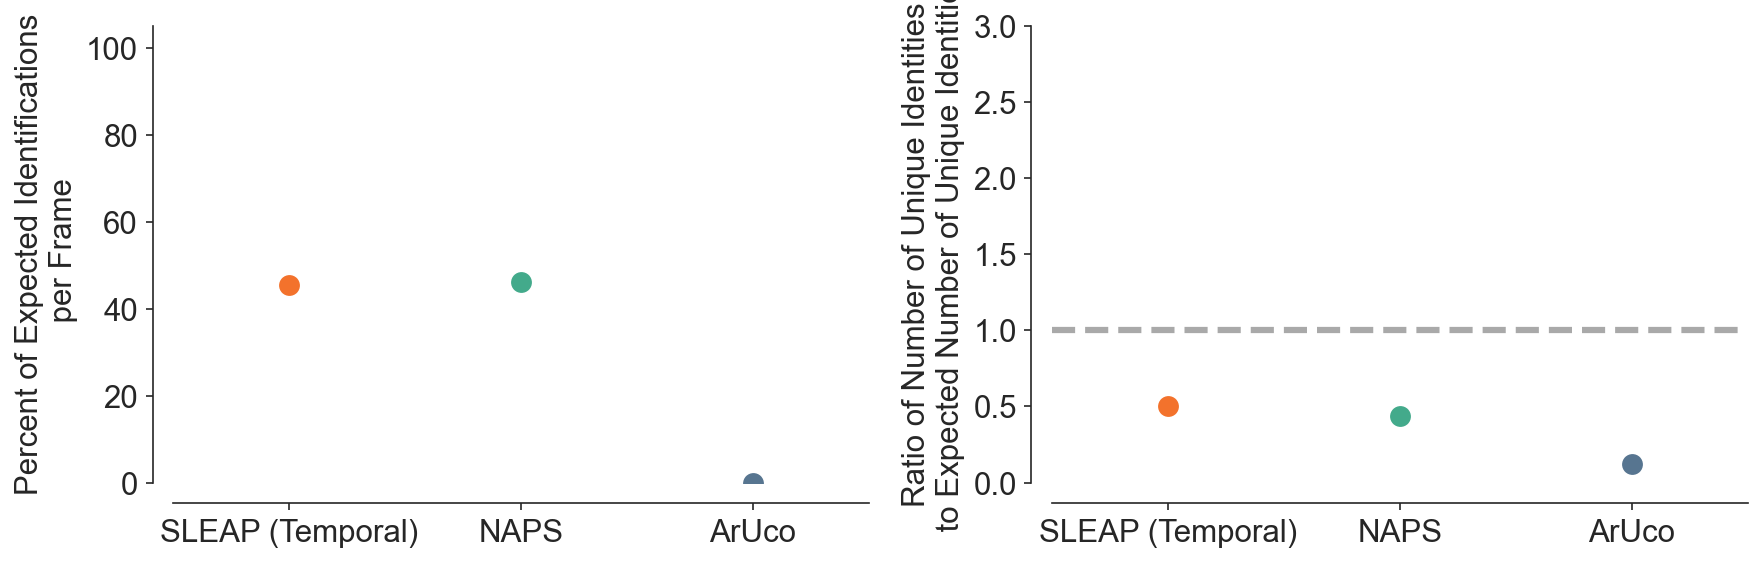

In [11]:
pal = [
    "#F3722C",
    "#43AA8B",
    "#577590",
]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.set_style("ticks")
import itertools

mean_identifications_sleap = [
    100
    * metadata_dict[expmt_name]["mean_identifications_sleap"]
    / metadata_dict[expmt_name]["n_individuals"]
    for expmt_name in metadata_dict.keys()
]
mean_identifications_naps = [
    (100 * metadata_dict[expmt_name]["mean_identifications_naps"] - 1)
    / metadata_dict[expmt_name]["n_expected_naps_tracks"]
    for expmt_name in metadata_dict.keys()
]
mean_identifications_aruco = [
    100
    * metadata_dict[expmt_name]["mean_identifications_aruco"]
    / metadata_dict[expmt_name]["n_expected_naps_tracks"]
    for expmt_name in metadata_dict.keys()
]
list_of_missing_freqs = [
    mean_identifications_sleap,
    mean_identifications_naps,
    mean_identifications_aruco,
]
data = pd.DataFrame(
    (_ for _ in itertools.zip_longest(*list_of_missing_freqs)),
    columns=["SLEAP (Temporal)", "NAPS", "ArUco"],
)
sns.swarmplot(
    ax=ax[0],
    data=data,
    size=10,
    palette=pal,
)

ax[0].set_ylim(0, 105)
sns.despine(offset=10, trim=False)
ax[0].set_ylabel("Percent of Expected Identifications\n per Frame")

mean_identifications_sleap = [
    metadata_dict[expmt_name]["occupancy_matrix_sleap"].shape[1]
    / metadata_dict[expmt_name]["n_individuals"]
    for expmt_name in metadata_dict.keys()
]
mean_identifications_naps = [
    (metadata_dict[expmt_name]["occupancy_matrix_naps"].shape[1] - 1)
    / metadata_dict[expmt_name]["n_expected_naps_tracks"]
    for expmt_name in metadata_dict.keys()
]
mean_identifications_aruco = [
    metadata_dict[expmt_name]["occupancy_matrix_aruco"].shape[1]
    / metadata_dict[expmt_name]["n_expected_naps_tracks"]
    for expmt_name in metadata_dict.keys()
]
list_of_track_counts = [
    mean_identifications_sleap,
    mean_identifications_naps,
    mean_identifications_aruco,
]

data = pd.DataFrame(
    (_ for _ in itertools.zip_longest(*list_of_track_counts)),
    columns=["SLEAP (Temporal)", "NAPS", "ArUco"],
)
sns.swarmplot(
    ax=ax[1],
    data=data,
    palette=pal,
    size=10,
)
plt.axhline(1, lw=3, color="darkgray", ls="--")
plt.ylim(0, 3)
sns.despine(offset=10, trim=False)
ax[1].set_ylabel(
    "Ratio of Number of Unique Identities\n to Expected Number of Unique Identities"
)
plt.tight_layout()
plt.savefig("docs/figures/naps_comparison_metrics.png", dpi=600, bbox_inches="tight")